# Setup

In [1]:
with open('../data/names.txt') as names_file:
    words = names_file.read().splitlines()

words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [2]:
len(words)

32033

In [3]:
max(len(word) for word in words)

15

In [4]:
from string import ascii_lowercase

from torchtext.vocab import build_vocab_from_iterator

STOP = "."

vocab = build_vocab_from_iterator([STOP] + list(ascii_lowercase))

In [5]:
import random

random.seed(42)
random.shuffle(words)

In [6]:
import torch

# context length: how many characters do we take to predict the next one?
block_size = 8

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = vocab[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  context = [vocab.lookup_token(ix.item()) for ix in x]
  predicted = y.item()
  print(''.join(context), '-->', vocab.lookup_token(predicted))

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# Model

In [14]:
torch.manual_seed(42);

In [108]:
import torch
from torch import nn

class Coalesce(nn.Module):
  to_dim: "int"
  from_dim: "int"
  factor: "int"

  def __init__(self, dim: "int", factor: "int"):
    super().__init__()
    self.dim = dim
    self.factor = factor

  def forward(self, x):
    x_shape = [*x.shape]

    # determine shape of output tensor
    target_shape = []
    for i, dim in enumerate(x_shape):
      if i == self.dim:
        target_shape.append(dim // self.factor)
      elif i == self.dim + 1:
        target_shape.append(dim * self.factor)
      else:
        target_shape.append(dim)

    x = x.reshape(*target_shape)

    if target_shape[self.dim] == 1:
      x = x.squeeze(self.dim)
    
    return x

class Transpose(nn.Module):
  def __init__(self, dim0: "int", dim1: "int"):
    super().__init__()
    self.dim0 = dim0
    self.dim1 = dim1

  def forward(self, x):
    return torch.transpose(x, self.dim0, self.dim1)

In [115]:
import torch

from torch.nn import (
    Sequential,
    Embedding,
    Linear,
    BatchNorm1d,
    Tanh
)

dim_emb = 32 # dimensionality of embedding vectors
dim_h = 128 # number of neurons in the hidden layer

model = Sequential(
    Embedding(len(vocab), dim_emb),
    Coalesce(dim=1, factor=2), Linear(dim_emb * 2, dim_h), Transpose(1, 2), BatchNorm1d(dim_h), Transpose(1, 2), Tanh(),
    Coalesce(dim=1, factor=2), Linear(dim_h * 2, dim_h), Transpose(1, 2), BatchNorm1d(dim_h), Transpose(1, 2), Tanh(),
    Coalesce(dim=1, factor=2), Linear(dim_h * 2, dim_h), BatchNorm1d(dim_h), Tanh(),
    Linear(dim_h, len(vocab)),
)

# parameter initialization
with torch.no_grad():
    layers = list(model.children())
    layers[-1].weight *= 0.1 # reduce confidence of output layer

for p in model.parameters():
    p.requires_grad = True

sum(p.numel() for p in model.parameters())


79227

In [116]:
import torch

i = torch.randint(0, len(Xtr), (16,))
x = Xtr[i]

print("Input", tuple([*x.shape]))

for child in model.children():
    name = child.__class__.__name__
    x = child(x)
    print(name, tuple([*x.shape]))


Input (16, 8)
Embedding (16, 8, 32)
Coalesce (16, 4, 64)
Linear (16, 4, 128)
Transpose (16, 128, 4)
BatchNorm1d (16, 128, 4)
Transpose (16, 4, 128)
Tanh (16, 4, 128)
Coalesce (16, 2, 256)
Linear (16, 2, 128)
Transpose (16, 128, 2)
BatchNorm1d (16, 128, 2)
Transpose (16, 2, 128)
Tanh (16, 2, 128)
Coalesce (16, 256)
Linear (16, 128)
BatchNorm1d (16, 128)
Tanh (16, 128)
Linear (16, 27)


In [117]:
from torch.nn.functional import cross_entropy

max_steps = 200_000
batch_size = 32
lossi = []

# training mode
model.train()

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, len(Xtr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)

    loss = cross_entropy(logits, Yb)

    # backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # update (simple sgd)
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in model.parameters():
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    if i % 10_000 == 0:
        print(f"{i} / {max_steps}: {loss.item():.4f}")

0 / 200000: 3.3028
10000 / 200000: 2.1892
20000 / 200000: 1.9966
30000 / 200000: 1.8100
40000 / 200000: 1.7562
50000 / 200000: 2.0985
60000 / 200000: 2.3251
70000 / 200000: 1.7686
80000 / 200000: 1.9305
90000 / 200000: 1.8252
100000 / 200000: 1.7751
110000 / 200000: 1.9933
120000 / 200000: 2.2303
130000 / 200000: 1.8829
140000 / 200000: 1.7976
150000 / 200000: 1.7899
160000 / 200000: 1.8762
170000 / 200000: 1.7405
180000 / 200000: 1.7684
190000 / 200000: 1.8632


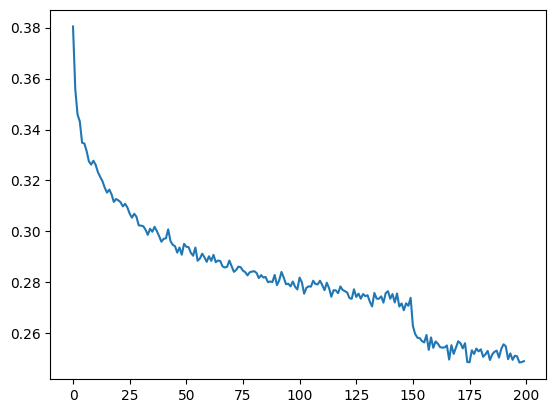

In [118]:
import matplotlib.pyplot as plt

# mean for losses in 1k batches
loss_u = torch.tensor(lossi).view(-1, 1000).mean(dim=1)

plt.plot(loss_u);

In [119]:
import torch
from torch.nn.functional import cross_entropy

model.eval()

@torch.no_grad()
def split_loss(split: "str"):
    splits = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }

    X, Y = splits[split]

    logits = model(X)
    loss = cross_entropy(logits, Y)

    print(split, loss.item())

split_loss("train")
split_loss("dev")

train 1.7648465633392334
dev 1.9897912740707397


In [120]:
import torch
from torch.nn.functional import softmax

for _ in range(20):
    out = []
    context = [0] * block_size # initialize context
    while True:
        logits = model(torch.tensor([context]))
        probs = softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        predicted = vocab.lookup_token(ix)

        # predicted end of word?
        if predicted == STOP:
            break

        # update output and shift context
        out.append(predicted)
        context = context[1:] + [ix]
    
    print("".join(out))

kinseus
dearin
aporit
corlend
zayveon
deeka
jacey
adrold
dimsan
prezley
srew
amaus
kalieya
beatla
izey
zarethi
brennemeer
octau
bezelah
alexandra
